#A MACHINE LEARNING-BASED APPROACH TO CLASSIFY STUDENTS FOR RECRUITMENT (#1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.combine import SMOTETomek
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Load Data

In [2]:
df = pd.read_excel("sample_data/Data Placement.xlsx")
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN


#Rename Columns

In [3]:
#rename columns
df.rename(columns=df.iloc[0], inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN


In [4]:
#drop 0th index
df.drop(index=0, inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
5,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


In [5]:
#reset index
df.reset_index(inplace=True)
df.head()

,index,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
2,3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
3,4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
4,5,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


In [6]:
#drop 'index' column
df.drop(columns='index', inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


#NaN in Placement Status -> Not Placed

In [7]:
df['Placement Status'] = df['Placement Status'].fillna('Not Placed')
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,Not Placed
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,Not Placed
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,Not Placed
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,Not Placed


#Setting Target in 0/1 Format
##0 -> Positive (or Placed)
##1 -> Negative (or Not Placed)

In [8]:
df['Placement Status'].replace("Placed", 0, inplace=True)
df['Placement Status'].replace("Not Placed", 1, inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,0
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,1
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,1
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,1
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12864 entries, 0 to 12863
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Branch                12864 non-null  object
 1   Degree                12864 non-null  object
 2   Aptitude              12864 non-null  object
 3   English               12864 non-null  object
 4   Quantitative          12864 non-null  object
 5   Analytical            12864 non-null  object
 6   Domain                12864 non-null  object
 7   Computer Fundamental  12864 non-null  object
 8   Coding                12864 non-null  object
 9   Placement Status      12864 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 1005.1+ KB


#Data Type Conversion

In [10]:
df['Aptitude'] = (pd.to_numeric(df['Aptitude'], errors='coerce', downcast='float')).astype('float64')
df['English'] = (pd.to_numeric(df['English'], errors='coerce', downcast='float')).astype('float64')
df['Quantitative'] = (pd.to_numeric(df['Quantitative'], errors='coerce', downcast='float')).astype('float64')
df['Analytical'] = (pd.to_numeric(df['Analytical'], errors='coerce', downcast='float')).astype('float64')
df['Domain'] = (pd.to_numeric(df['Domain'], errors='coerce', downcast='float')).astype('float64')
df['Computer Fundamental'] = (pd.to_numeric(df['Computer Fundamental'], errors='coerce', downcast='float')).astype('float64')
df['Coding'] = (pd.to_numeric(df['Coding'], errors='coerce', downcast='float')).astype('float64')
df.dtypes

Branch                   object
Degree                   object
Aptitude                float64
English                 float64
Quantitative            float64
Analytical              float64
Domain                  float64
Computer Fundamental    float64
Coding                  float64
Placement Status          int64
dtype: object

#Missing Values Treatment

##Finding missing value locations

In [11]:
df.isnull().sum()

Branch                  0
Degree                  0
Aptitude                1
English                 0
Quantitative            0
Analytical              0
Domain                  0
Computer Fundamental    0
Coding                  0
Placement Status        0
dtype: int64

##Handling missing values

In [12]:
#imputing mode (based on Placement Status)
def impute_nan(d, variable):
  #Placement Status = 0
  idx_0 = d[d['Placement Status'] == 0].index.tolist() #indexes
  var_0 = d.loc[idx_0, variable] #feature
  var_0_mode = var_0.mode()[0] #mode
  
  #Placement Status = 1
  idx_1 = d[d['Placement Status'] == 1].index.tolist()  #indexes  
  var_1 = d.loc[idx_1, variable] #feature 
  var_1_mode = var_1.mode()[0] #mode

  #NaNs    
  idx_nan = d[d[variable].isnull()].index.tolist() #indexes
  for i in range(len(idx_nan)):
    if d.loc[idx_nan[i], 'Placement Status'] == 0:
      d.loc[idx_nan[i], variable] = var_0_mode
    else:
      d.loc[idx_nan[i], variable] = var_1_mode
  
  return d

In [13]:
#df.dropna(inplace=True)
df = impute_nan(df, 'Aptitude')
df.isnull().sum()

Branch                  0
Degree                  0
Aptitude                0
English                 0
Quantitative            0
Analytical              0
Domain                  0
Computer Fundamental    0
Coding                  0
Placement Status        0
dtype: int64

#Drop Unwanted Columns

##In this case Branch	& Degree, as Branch	& Degree doesn't play important role in Campus Placement.

In [14]:
df2 = df.drop(columns=['Branch',	'Degree'])
df2.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0,0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0,1
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0,1
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0,1
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0,1


#Count (Positive class and Negative class)

In [15]:
unique_class, counts_class = np.unique(df['Placement Status'], return_counts=True)
dict(zip(unique_class, counts_class))

{0: 767, 1: 12097}

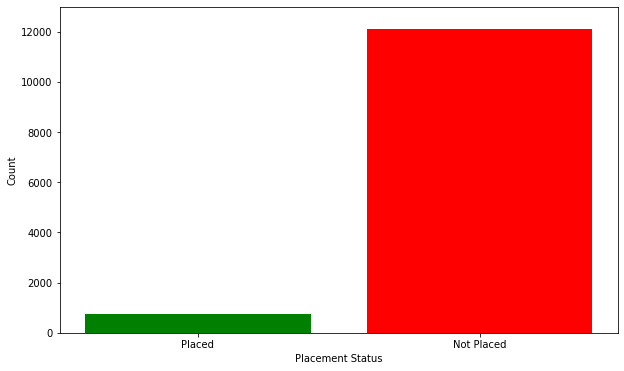

In [16]:
cY = counts_class.tolist()
cls = unique_class.tolist()
cls_label = []
for c in cls:
  if c == 0:
    cls_label.append('Placed')
  else:
    cls_label.append('Not Placed')

plt.figure(figsize=(10,6))
plt.bar(cls_label, cY, color=['Green', 'Red'])
plt.xlabel("Placement Status")
plt.ylabel('Count')
plt.ylim(0, 13000)
plt.show()

##*Imbalanced data*

#Handling Imbalanced Data - *Over Sampling*

##Separating Features & Labels

In [17]:
x = df2.drop(columns='Placement Status')
x.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0


In [18]:
y = df2['Placement Status']
y.head()

0    0
1    1
2    1
3    1
4    1
Name: Placement Status, dtype: int64

##Oversampling

In [19]:
smk = SMOTETomek(ratio=1)
x_res, y_res = smk.fit_sample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [20]:
unique_y_res, counts_y_res = np.unique(y_res, return_counts=True)
dict(zip(unique_y_res, counts_y_res))

{0: 12095, 1: 12095}

#Count (Positive class and Negative class)

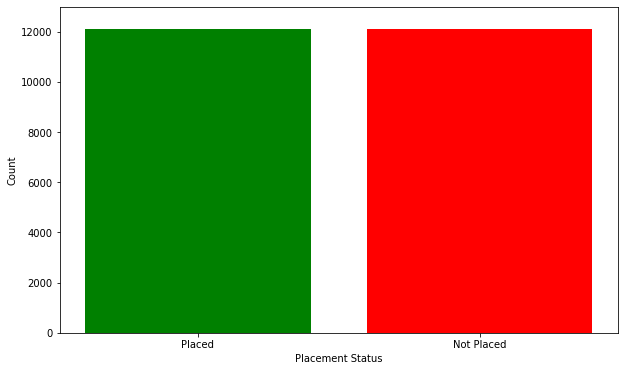

In [21]:
cY = counts_y_res.tolist()
cls = unique_y_res.tolist()
cls_label = []
for c in cls:
  if c == 0:
    cls_label.append('Placed')
  else:
    cls_label.append('Not Placed')

plt.figure(figsize=(10,6))
plt.bar(cls_label, cY, color=['Green', 'Red'])
plt.xlabel("Placement Status")
plt.ylabel('Count')
plt.ylim(0, 13000)
plt.show()

##*Balanced data*

#Final Features & Labels

In [22]:
features = pd.DataFrame(x_res, columns=x.columns)
features.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0


In [23]:
labels = pd.Series(y_res, name=y.name)
labels.head()

0    0
1    1
2    1
3    1
4    1
Name: Placement Status, dtype: int64

In [ ]:
"""
#exporting the oversampled data to csv
temp = features
temp['Placement Status'] = labels
temp.to_csv('temp.csv', index=False)
"""

#Classifier Selection

In [ ]:
df3 = features.copy() 
df3['Placement Status'] = labels
df3.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0,0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0,1
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0,1
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0,1
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0,1


##MultiVariate Analysis

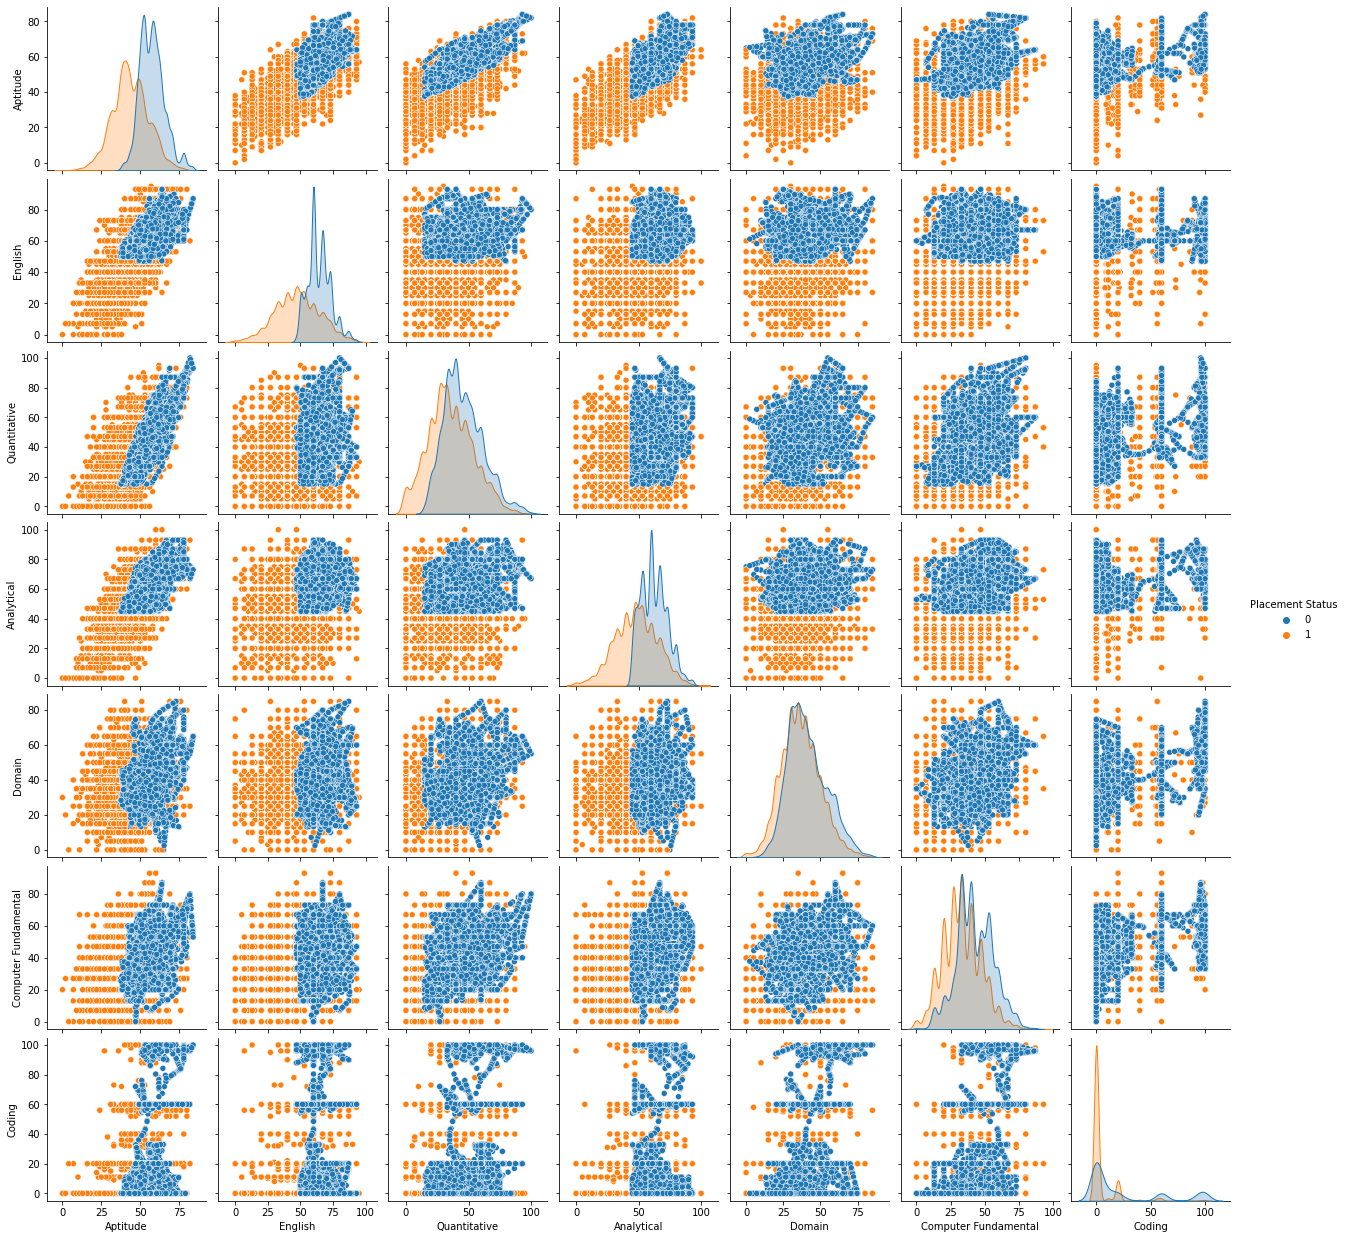

In [ ]:
sns.pairplot(df3, hue="Placement Status")

###*1. Non-linearly separable data.*
###*2. The data cannot be classified perfectly by a linear classifier (Logistic Regression, SVM).*
###*3. To solve this classification problem a non-linear classifier (KNN, Decision Tree, Ensemble Models) is a good choice.*

#Train-Test Split

In [24]:
features_trainval, features_test, labels_trainval, labels_test = train_test_split(features, labels, test_size=0.3, random_state=0)

#Data Pre-processing

In [25]:
#training-validation data
scaler = MinMaxScaler()
X_trainval = scaler.fit_transform(features_trainval)  #(X - Xmin)/(Xmax - Xmin)
df_X_trainval = pd.DataFrame(data=X_trainval, columns=features.columns)
df_X_trainval.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,0.714286,0.631579,0.53,0.67,0.235294,0.354839,0.2
1,0.607143,0.421053,0.40,0.73,0.352941,0.290323,0.0
2,0.452381,0.494737,0.27,0.40,0.235294,0.290323,0.0
3,0.523810,0.705263,0.00,0.67,0.117647,0.430108,0.0
4,0.607143,0.494737,0.33,0.73,0.176471,0.139785,0.0


In [ ]:
#testing data
X_test = scaler.transform(features_test)
df_X_test = pd.DataFrame(data=X_test, columns=features.columns)
df_X_test.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,0.476190,0.347368,0.400000,0.470000,0.588235,0.139785,0.200000
1,0.357143,0.473684,0.000000,0.450000,0.152941,0.139785,0.000000
2,0.630952,0.758987,0.214937,0.664025,0.418794,0.550619,0.170126
3,0.761905,0.768421,0.670000,0.530000,0.176471,0.215054,0.200000
4,0.616222,0.687029,0.452677,0.465051,0.417587,0.569892,0.000000


In [26]:
#training-validation data count
Y_trainval = labels_trainval
unique_Y_trainval, counts_Y_trainval = np.unique(Y_trainval, return_counts=True)
dict(zip(unique_Y_trainval, counts_Y_trainval))

{0: 8478, 1: 8455}

In [ ]:
#testing data count
Y_test = labels_test
unique_Y_test, counts_Y_test = np.unique(Y_test, return_counts=True)
dict_Y_test = dict(zip(unique_Y_test, counts_Y_test))
dict_Y_test

{0: 3623, 1: 3635}

#Building models

##KNN

###Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
HP_knn = {'n_neighbors':[3,5,7,9]}

tuning_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=HP_knn, scoring='accuracy')
tuning_knn.fit(X_trainval, Y_trainval)
tuning_knn.best_params_, tuning_knn.best_score_

({'n_neighbors': 3}, 0.9434865877331257)

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=3) #n_classes % n_neighbors != 0

##Decision Tree

In [ ]:
clf_dt = DecisionTreeClassifier()

#StratifiedKFold Cross Validation

In [ ]:
X = np.array(X_trainval)
Y = np.array(Y_trainval)

#training score
train_score_knn = []
train_score_dt = []
#training time
train_time_knn = []
train_time_dt = []
#validation accuracy
val_accuracy_knn = []
val_accuracy_dt = []

skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, Y)

for train_index, val_index in skf.split(X, Y):  
  X1_train, X1_val = X[train_index], X[val_index]
  Y1_train, Y1_val = Y[train_index], Y[val_index]
   
  #training
  #KNN    
  st_train_knn = time.time()  #start time
  clf_knn.fit(X1_train, Y1_train)  
  et_train_knn = time.time()  #end time
  train_score_knn.append(clf_knn.score(X1_train, Y1_train))
  train_time_knn.append(et_train_knn - st_train_knn)
  #DT    
  st_train_dt = time.time()  #start time
  clf_dt.fit(X1_train, Y1_train)  
  et_train_dt = time.time()  #end time
  train_score_dt.append(clf_dt.score(X1_train, Y1_train))
  train_time_dt.append(et_train_dt - st_train_dt)

  #validation
  #KNN  
  prediction_knn = clf_knn.predict(X1_val)      
  val_accuracy_knn.append(accuracy_score(Y1_val, prediction_knn))
  #DT  
  prediction_dt = clf_dt.predict(X1_val)      
  val_accuracy_dt.append(accuracy_score(Y1_val, prediction_dt))

#training score  
train_score_knn = np.array(train_score_knn)
train_score_dt = np.array(train_score_dt)
#training time
train_time_knn = np.array(train_time_knn)
train_time_dt = np.array(train_time_dt)
#validation accuracy
val_accuracy_knn = np.array(val_accuracy_knn)
val_accuracy_dt = np.array(val_accuracy_dt)

In [ ]:
#KNN
train_score_knn.mean(), train_time_knn.mean(), val_accuracy_knn.mean()

(0.9729833706033367, 0.018091758092244465, 0.9374632798897355)

In [ ]:
#DT
train_score_dt.mean(), train_time_dt.mean(), val_accuracy_dt.mean()

(0.9992027872904489, 0.04637956619262695, 0.978504838925336)

#Testing Phase

In [ ]:
#KNN
Y_pred_knn = clf_knn.predict(X_test)
test_score_knn = accuracy_score(Y_test, Y_pred_knn)
test_score_knn

0.93744833287407

In [ ]:
#DT
Y_pred_dt = clf_dt.predict(X_test)
test_score_dt = accuracy_score(Y_test, Y_pred_dt)
test_score_dt

0.9805731606503169

#Confusion Matrix

In [ ]:
#KNN
conf_mat_knn = confusion_matrix(Y_test, Y_pred_knn)
conf_mat_knn

array([[3611,   12],
       [ 442, 3193]])

In [ ]:
#DT
conf_mat_dt = confusion_matrix(Y_test, Y_pred_dt)
conf_mat_dt

array([[3587,   36],
       [ 105, 3530]])

#Classification Report

In [ ]:
#KNN
classification_report_knn = classification_report(Y_test, Y_pred_knn, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_knn = pd.DataFrame(classification_report_knn).transpose()
df_classification_report_knn

,precision,recall,f1-score,support
Placed,0.890945,0.996688,0.940855,3623.000000
Not Placed,0.996256,0.878404,0.933626,3635.000000
accuracy,0.937448,0.937448,0.937448,0.937448
macro avg,0.943600,0.937546,0.937240,7258.000000
weighted avg,0.943687,0.937448,0.937234,7258.000000


In [ ]:
#DT
classification_report_dt = classification_report(Y_test, Y_pred_dt, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_dt = pd.DataFrame(classification_report_dt).transpose()
df_classification_report_dt

,precision,recall,f1-score,support
Placed,0.971560,0.990063,0.980725,3623.000000
Not Placed,0.989905,0.971114,0.980419,3635.000000
accuracy,0.980573,0.980573,0.980573,0.980573
macro avg,0.980732,0.980589,0.980572,7258.000000
weighted avg,0.980748,0.980573,0.980572,7258.000000


#Testing with Outside Data

In [ ]:
outside_data = np.array([58, 71, 42,	50,	59,	51, 95])
outside_data = scaler.transform(outside_data.reshape(1, -1)) #data pre-processing

In [ ]:
#KNN
clf_knn.predict(outside_data)

array([0])

In [ ]:
#DT
clf_dt.predict(outside_data)

array([1])

#Model Comparison 
##(KNN, Decision Tree)

In [ ]:
model = ['KNN', 'DT']

##wrt TP, FN, FP, and TN

In [ ]:
tp_fn_fp_tn = np.array([       
                        [conf_mat_knn[0][0], conf_mat_knn[0][1], conf_mat_knn[0][0]+conf_mat_knn[0][1], conf_mat_knn[1][0], conf_mat_knn[1][1], conf_mat_knn[1][0]+conf_mat_knn[1][1]],
                        [conf_mat_dt[0][0], conf_mat_dt[0][1], conf_mat_dt[0][0]+conf_mat_dt[0][1], conf_mat_dt[1][0], conf_mat_dt[1][1], conf_mat_dt[1][0]+conf_mat_dt[1][1]]
                        ])
model_tp_fn_fp_tn = pd.DataFrame(data=tp_fn_fp_tn, columns=['TP', 'FN', 'P (Placed)', 'FP', 'TN', 'N (Not Placed)'], index=model)
model_tp_fn_fp_tn

,TP,FN,P (Placed),FP,TN,N (Not Placed)
KNN,3611,12,3623,442,3193,3635
DT,3587,36,3623,105,3530,3635


##wrt Precision, Recall, and F1-Score

In [ ]:
precision_recall_f1_score = np.array([                                      
                                      [df_classification_report_knn.loc['Placed', 'precision'], df_classification_report_knn.loc['Not Placed', 'precision'], df_classification_report_knn.loc['Placed', 'recall'], df_classification_report_knn.loc['Not Placed', 'recall'], df_classification_report_knn.loc['Placed', 'f1-score'], df_classification_report_knn.loc['Not Placed', 'f1-score']],                                      
                                      [df_classification_report_dt.loc['Placed', 'precision'], df_classification_report_dt.loc['Not Placed', 'precision'], df_classification_report_dt.loc['Placed', 'recall'], df_classification_report_dt.loc['Not Placed', 'recall'], df_classification_report_dt.loc['Placed', 'f1-score'], df_classification_report_dt.loc['Not Placed', 'f1-score']]
                                      ])
model_precision_recall_f1_score = pd.DataFrame(data=precision_recall_f1_score, columns=['Precision (Placed)', 'Precision (Not Placed)', 'Recall (Placed)', 'Recall (Not Placed)', 'F1-Score (Placed)', 'F1-Score (Not Placed)'], index=model)
model_precision_recall_f1_score

,Precision (Placed),Precision (Not Placed),Recall (Placed),Recall (Not Placed),F1-Score (Placed),F1-Score (Not Placed)
KNN,0.890945,0.996256,0.996688,0.878404,0.940855,0.933626
DT,0.971560,0.989905,0.990063,0.971114,0.980725,0.980419


##wrt Training Score, Validation Accuracy, and Testing Accuracy

In [ ]:
train_val_test_score = np.array([
                                 [train_score_knn.mean(), val_accuracy_knn.mean(), df_classification_report_knn.loc['accuracy', 'support']],
                                 [train_score_dt.mean(), val_accuracy_dt.mean(), df_classification_report_dt.loc['accuracy', 'support']]
                                ])
model_train_val_test_score = pd.DataFrame(data=train_val_test_score, columns=['Training Score', 'Validation Accuracy', 'Testing Accuracy'], index=model)
model_train_val_test_score

,Training Score,Validation Accuracy,Testing Accuracy
KNN,0.972983,0.937463,0.937448
DT,0.999203,0.978505,0.980573


##wrt Training Time

In [ ]:
train_time = np.array([
                       [train_time_knn.mean()],
                       [train_time_dt.mean()]
                      ])
model_train_time = pd.DataFrame(data=train_time, columns=['Training Time'], index=model)
model_train_time

,Training Time
KNN,0.018092
DT,0.046380


#Model Rankings



##in terms of Testing Accuracy

In [ ]:
#sorting
clf_rank_test = model_train_val_test_score.sort_values(by=['Testing Accuracy'], ascending=False)

#ranking
clf_rank_test['Rank'] = clf_rank_test['Testing Accuracy'].rank(method='max', ascending=False)

#dropping columns
clf_rank_test.drop(columns=['Training Score',	'Validation Accuracy'], inplace=True)

clf_rank_test

,Testing Accuracy,Rank
DT,0.980573,1.0
KNN,0.937448,2.0


##in terms of Training Time

In [ ]:
#sorting
clf_rank_train_time = model_train_time.sort_values(by=['Training Time'])

#ranking
clf_rank_train_time['Rank'] = clf_rank_train_time['Training Time'].rank(method='min')

clf_rank_train_time

,Training Time,Rank
KNN,0.018092,1.0
DT,0.046380,2.0


#Conclusion
##FOCUS: Accuracy
##BEST MODEL: KNN*
##*Decision Tree's accuracy is higher than KNN's, but it predicts incorrectly for the Outside Data.


#Feature Rankings

##using Mutual Information

In [32]:
from sklearn.feature_selection import mutual_info_classif

In [41]:
#determine the mutual information
mutual_info = mutual_info_classif(X_trainval, Y_trainval)
mutual_info

array([0.44239041, 0.42059167, 0.31601627, 0.37201208, 0.32858851,
       0.24715324, 0.1348095 ])

In [42]:
#sorting the mutual information
mutual_info = pd.Series(mutual_info)
mutual_info.index = df_X_trainval.columns
mutual_info.sort_values(ascending=False)

Aptitude                0.442390
English                 0.420592
Analytical              0.372012
Domain                  0.328589
Quantitative            0.316016
Computer Fundamental    0.247153
Coding                  0.134810
dtype: float64

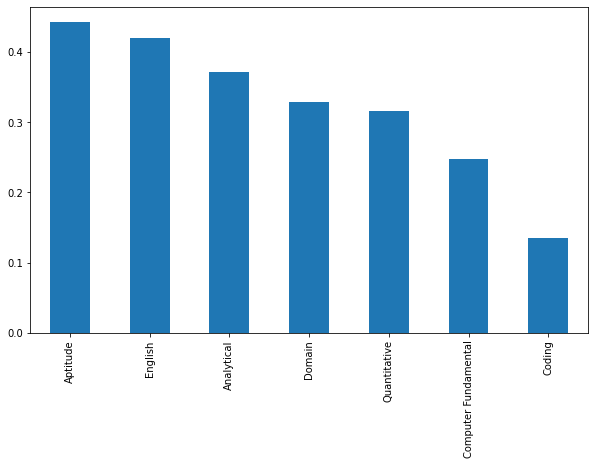

In [43]:
#plotting the ordered mutual information values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 6))